In [ ]:
!pip install opencv-python tensorflow fastapi uvicorn streamlit kaggle matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 106.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.4 MB/s eta 0:00:00


In [ ]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d asdasdasasdas/garbage-classification
!unzip garbage-classification.zip -d garbage_data

Streaming output truncated to the last 5000 lines.
  inflating: garbage_data/Garbage classification/Garbage classification/cardboard/cardboard152.jpg  
  inflating: garbage_data/Garbage classification/Garbage classification/cardboard/cardboard153.jpg  
  inflating: garbage_data/Garbage classification/Garbage classification/cardboard/cardboard154.jpg  
  inflating: garbage_data/Garbage classification/Garbage classification/cardboard/cardboard155.jpg  
  inflating: garbage_data/Garbage classification/Garbage classification/cardboard/cardboard156.jpg  
  inflating: garbage_data/Garbage classification/Garbage classification/cardboard/cardboard157.jpg  
  inflating: garbage_data/Garbage classification/Garbage classification/cardboard/cardboard158.jpg  
  inflating: garbage_data/Garbage classification/Garbage classification/cardboard/cardboard159.jpg  
  inflating: garbage_data/Garbage classification/Garbage classification/cardboard/cardboard16.jpg  
  inflating: garbage_data/Garbage classif

In [ ]:
import os
base_dir="garbage_data/Garbage classification/Garbage classification"
print("Classes available:",os.listdir(base_dir))

Classes available: ['cardboard', 'metal', 'paper', 'glass', 'trash', 'plastic']


In [ ]:
#Oprimizing the images for model building
import tensorflow as tf
batch_size=32
img_size=(224,224)
train_ds=tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)
val_ds=tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)
class_names=train_ds.class_names
print("Class names:",class_names)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


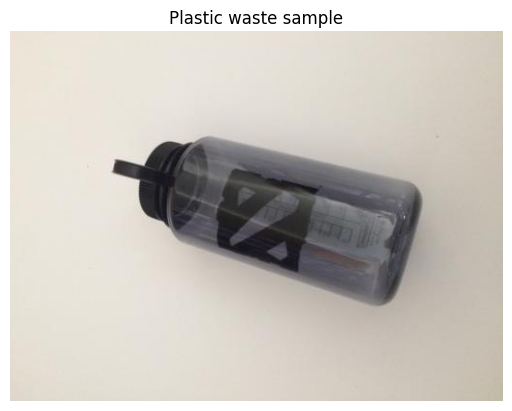

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
image_path=f"{base_dir}/plastic/plastic1.jpg"
img_rgb=cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title("Plastic waste sample")
plt.axis("off")
plt.show()

In [ ]:
AUTOTUNE=tf.data.AUTOTUNE
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)
#

**DATA Preprocessing and understanding**
!.understanding the data strucutre 2.Processing
1.resize
2.Normalize
3.Augument

In [ ]:
classes=os.listdir(base_dir)
num_classes=len(classes)
print(f"Number of classes:{num_classes}")
total_images=0
for c in classes:
  images=os.listdir(os.path.join(base_dir,c))
  total_images+=len(images)
  print(f"for category {c}.We have {len(images)} images")
print(f"Total images:{total_images}")

Number of classes:6
for category cardboard.We have 403 images
for category metal.We have 410 images
for category paper.We have 594 images
for category glass.We have 501 images
for category trash.We have 137 images
for category plastic.We have 482 images
Total images:2527


In [ ]:
#model building
#from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers,models
base_model=MobileNetV2(input_shape=img_size+(3,),include_top=False,weights="imagenet")
base_model.trainable=False #Freeze the base model
model=models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(228,activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(6,activation="softmax") #6 Classes
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#|Step|Task                              |Analogy                                  |
#|----|----------------------------------|------------------------------------     |
#|1   |Build the CNN Model               |Design the brain structure(like neurons) |
#|2   |Compile the model                 |Set rules for learning(optimizer&loss)   |
#|3   |Train the model                   |Teach the AI using flashcard(images)     |
#|4   |Evaluate the model                |Give the AI a small test                 |
#|5   |Save the trained model            |Save the brain for future use(API&App)   |

In [ ]:
model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history=model.fit(train_ds,validation_data=val_ds,epochs=25)

Epoch 1/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9753 - loss: 0.1013 - val_accuracy: 0.7584 - val_loss: 0.8629
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9781 - loss: 0.0856 - val_accuracy: 0.7446 - val_loss: 0.8867
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9811 - loss: 0.0801 - val_accuracy: 0.7267 - val_loss: 1.0150
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9665 - loss: 0.1194 - val_accuracy: 0.7446 - val_loss: 0.8842
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9702 - loss: 0.1006 - val_accuracy: 0.7485 - val_loss: 0.9208
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9877 - loss: 0.0554 - val_accuracy: 0.7426 - val_loss: 0.9451
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9892 - loss: 0.0582 - val_accuracy: 0.7406 - val_loss: 0.9337
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9842 - loss: 0.0620 - val_accuracy: 0.7426 - val_lo

In [ ]:
#Saving your model
model.save('waste_classifier_model.h5')

In [33]:
from tensorflow.keras.models import load_model
model=load_model('waste_classifier_model.h5')

Saving glass4.jpg to glass4 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


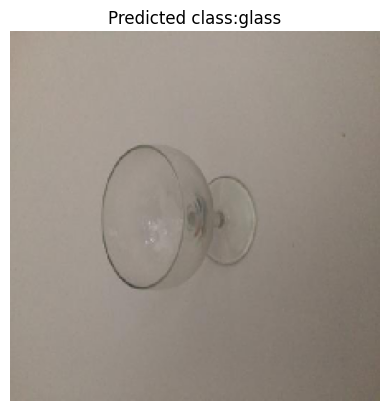

In [47]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
#load the trained model
model=tf.keras.models.load_model("waste_classifier_model.h5")
#Class labels
class_names=["cardboard","glass","metal","paper","plastic","trash"]
#upload image manually with colab
from google.colab import files
uploaded=files.upload()
#preprocess input for MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
for file_name in uploaded.keys():
  #load and preprocess the image
  img_path=file_name
#load and resize the image to 224*224
img=image.load_img(img_path,target_size=(224,224))    #----fixed
img_array=image.img_to_array(img)
img_array=np.expand_dims(img_array,axis=0)    #adding the batch dimensions
img_array=preprocess_input(img_array)   #mobilenetv2 preprocessing
#predict
prediction=model.predict(img_array)
predicted_class=class_names[np.argmax(prediction)]
#display the image with predicted results
plt.imshow(img)
plt.title(f"Predicted class:{predicted_class}")
plt.axis("off")
plt.show()